In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Flatten, Input, Activation, PReLU
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
import random
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import shap


### Import and clean data

In [2]:
# import excel sheet to pandas dataframe

df=pd.read_excel(open('../Data/SPS-Commorbiditiesver5.xlsx', 'rb'), sheet_name='Reorganized-with-labels')
df

,Past medical history item,1,2,3,7,8,9,10,11,12,...,47,48,49,50,51,52,53,54,55,Total
0,(psych) adjustment disorder with mixed emotion...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,(psych) adjustment insomnia,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,(psych) alcohol dependence in remission,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,(psych) antisocial personality disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,(psych) anxiety (unspecified),0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,Total number of Symptoms,10.0,8.0,45.0,26.0,6.0,17.0,11.0,11.0,3.0,...,11.0,3.0,1.0,5.0,16.0,22.0,8.0,9.0,10.0,NaN
328,isStiff,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,# Stiff,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#remove unnecessary rows
df=df.drop([327,329,330,331],axis=0)

#remove rows with all 0's
df = df.loc[~(df==0).all(axis=1)]

#Remove symptoms that only appear once (feature selection)
df = df[df.Total!= 1]
df = df[df.Total!= 2]


#remove last column
df = df.drop(labels='Total', axis=1)
df

,Past medical history item,1,2,3,7,8,9,10,11,12,...,46,47,48,49,50,51,52,53,54,55
4,(psych) anxiety (unspecified),0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,(psych) attention deficit hyperactivity disorder,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,(psych) behavior concern (unspecified),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,(psych) depression (unspecified),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,(psych) learning disability,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,(psych) major depressive disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
24,(psych) post traumatic stress disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,abnormal involuntary movement,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,amblyopia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
46,"anemia, iron deficiency",0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Vectorize Features and labels and split into train/test

In [4]:
#get rid of medical terms and separate features and labels
all_np=df.to_numpy().transpose()[1:].transpose()

all_np = np.asarray(all_np).astype('float32')

all_features=all_np[0:-1].transpose()
all_labels=all_np[-1].transpose()

print(all_features.shape)
print(all_features)

print(all_labels.shape)
print(all_labels)

(48, 51)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


In [5]:
psyc_df=df.copy()
psyc_df.drop(psyc_df.index[7:-1], inplace=True)
psyc_df

,Past medical history item,1,2,3,7,8,9,10,11,12,...,46,47,48,49,50,51,52,53,54,55
4,(psych) anxiety (unspecified),0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,(psych) attention deficit hyperactivity disorder,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,(psych) behavior concern (unspecified),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,(psych) depression (unspecified),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,(psych) learning disability,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,(psych) major depressive disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
24,(psych) post traumatic stress disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328,isStiff,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
#get rid of medical terms and separate features and labels
psyc_np=psyc_df.to_numpy().transpose()[1:].transpose()
psyc_np = np.asarray(psyc_np).astype('float32')

psyc_features=psyc_np[0:-1].transpose()
psyc_labels=psyc_np[-1].transpose()

print(psyc_features.shape)
print(psyc_features)

print(psyc_labels.shape)
print(psyc_labels)

(48, 7)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 

In [12]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

In [14]:
indexes=df.to_numpy().transpose()[0][0:-1]
indexes

array(['(psych) anxiety (unspecified)',
       '(psych) attention deficit hyperactivity disorder',
       '(psych) behavior concern (unspecified)',
       '(psych) depression (unspecified)', '(psych) learning disability',
       '(psych) major depressive disorder',
       '(psych) post traumatic stress disorder',
       'abnormal involuntary movement', 'amblyopia',
       'anemia, iron deficiency', 'asthma',
       'atherosclerotic cardiovascular disease', 'carpal tunnel syndrome',
       'cognitive impairment', 'colon polyps',
       'diabetes mellitus (unspecified)', 'diabetes mellitus, type 1',
       'diabetes mellitus, type 2 with diabetic neuropathy', 'diplopia',
       'dyslipidemia', 'dysphagia', 'dystonia (unspecified)',
       'encephalitis (unspecified)', 'encephalopathy (unspecified)',
       'epilepsy (unspecified)', 'fatigue', 'gait difficulty',
       'gastroesophageal reflux disease', "Hashimoto's disease",
       'headache (unspecified)', 'hypertension (unspecified)',


# Cross Validation with SVM

### With all features

In [1]:
skf = StratifiedKFold(n_splits=24,random_state=random.randint(0,300),shuffle=True)

rskf = RepeatedStratifiedKFold(n_splits=23, n_repeats=20, random_state=36851234)

total_score=0
k=0
for train_index, test_index in rskf.split(all_features, all_labels):
    print(str(k)+"th run")
    print("=====================================")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = all_features[train_index], all_features[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    
    clf = svm.SVC(probability=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    score=accuracy_score(y_test, y_pred)
    print(score)
    total_score=total_score+score
    print("=====================================")
    k=k+1

total_score=total_score/k
print("Total Score: " + str(total_score))

NameError: name 'StratifiedKFold' is not defined

In [79]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC

# for train_index, test_index in rskf.split(all_features, all_labels):
#     print(str(k)+"th run")
#     print("=====================================")
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = all_features[train_index], all_features[test_index]
#     y_train, y_test = all_labels[train_index], all_labels[test_index]

# clf = svm.SVC(kernel='linear')
# clf.fit(X_train, y_train)
# # svc = SVC().fit(X_train, y_train)
# # perm = PermutationImportance(clf).fit(X_test, y_test)
# eli5.show_weights(clf,top=51,feature_names=indexes)
# # eli5.explain_weights(clf,feature_names=indexes)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
perm = PermutationImportance(clf,n_iter=2).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = indexes,top=51)

Weight,Feature
0.0978 ± 0.0217,(psych) depression (unspecified)
0.0435 ± 0.0000,hypothyroidism (unspecified)
0.0217 ± 0.0000,obstructive sleep apnea
0.0217 ± 0.0435,"anemia, iron deficiency"
0.0109 ± 0.0217,fatigue
0.0109 ± 0.0217,irritable bowel syndrome
0.0109 ± 0.0217,(psych) behavior concern (unspecified)
0.0109 ± 0.0217,(psych) major depressive disorder
0.0109 ± 0.0217,"diabetes mellitus, type 1"
0.0109 ± 0.0217,dyslipidemia


In [8]:
clf = svm.SVC(kernel='linear')
rskf = RepeatedStratifiedKFold(n_splits=23, n_repeats=60, random_state=36851234)

cross_val_score(clf, all_features, all_labels, cv=rskf).mean()

0.6681159420289855

In [9]:
cv_results = cross_validate(clf, all_features, all_labels, cv=rskf, return_estimator = True,)
sorted(cv_results.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

In [10]:
total_svc_coef=np.zeros(np.shape(cv_results['estimator'][0].coef_[0]))
for i in range(len(cv_results['estimator'])):
    total_svc_coef=total_svc_coef+cv_results['estimator'][i].coef_[0]

total_svc_coef.shape

(51,)

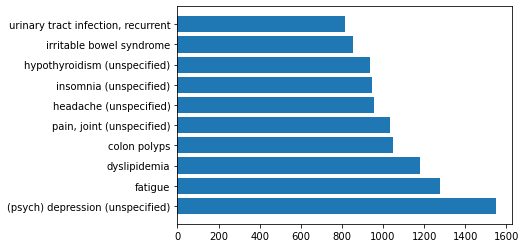

In [15]:
f_importances(abs(total_svc_coef), indexes, top=10)

### With Psyc Scores

In [16]:
skf = StratifiedKFold(n_splits=24,random_state=random.randint(0,300),shuffle=True)

rskf = RepeatedStratifiedKFold(n_splits=23, n_repeats=20, random_state=36851234)

total_score=0
k=0

for train_index, test_index in rskf.split(psyc_features, psyc_labels):
    print(str(k)+"th run")
    print("=====================================")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = psyc_features[train_index], psyc_features[test_index]
    y_train, y_test = psyc_labels[train_index], psyc_labels[test_index]
    
    clf = svm.SVC()
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    score=accuracy_score(y_test, y_pred)
    print(score)
    total_score=total_score+score
    print("=====================================")
    k=k+1

total_score=total_score/k
print("Total Score: " + str(total_score))

0th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [21 25 32]
0.6666666666666666
1th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 42 43 44 45 46 47] TEST: [ 3 36 41]
0.6666666666666666
2th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 34]
0.0
3th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 33]
0.5
4th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [13 28]
0.5
5th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29

0.0
66th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47] TEST: [27 46]
1.0
67th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 16]
0.5
68th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 41 42 43 44 45 46 47] TEST: [39 40]
0.5
69th run
TRAIN: [ 0  1  2  3  4  5  6  7  8 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 9 10 33]
0.6666666666666666
70th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [ 1 12 47]
0.6666666666666666
71th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 2

115th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 47] TEST: [22 35 46]
0.6666666666666666
116th run
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [ 6 31 43]
0.6666666666666666
117th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [23 36]
1.0
118th run
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 9 27]
1.0
119th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47] TEST: [12 41]
0.5
120th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25


0.5
171th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [15 30]
1.0
172th run
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47] TEST: [ 7 39]
0.5
173th run
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 4 18]
0.5
174th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47] TEST: [26 44]
0.5
175th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [21 29]
1.0
176th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 33 3

0.5
226th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47] TEST: [25 40]
0.5
227th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [26 42]
0.5
228th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 39 40 41 42 43 44 45 46 47] TEST: [12 38]
0.5
229th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47] TEST: [31 45]
0.5
230th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 47] TEST: [29 41 46]
0.6666666666666666
231th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 2

0.5
274th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [27 47]
1.0
275th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47] TEST: [26 37]
0.5
276th run
TRAIN: [ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0  9 36]
0.6666666666666666
277th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47] TEST: [26 37 44]
0.6666666666666666
278th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [24 43]
1.0
279th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24

0.5
314th run
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 5 28]
0.5
315th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 36]
0.5
316th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [24 47]
1.0
317th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47] TEST: [38 46]
0.5
318th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [15 31]
1.0
319th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 3

0.0
376th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 29]
0.5
377th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 28]
0.5
378th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 25]
0.5
379th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [20 24]
1.0
380th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [21 42]
1.0
381th run
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 3

0.5
451th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 2 36]
1.0
452th run
TRAIN: [ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [0 9]
0.5
453th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [14 29]
1.0
454th run
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [ 6 43]
0.5
455th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [13 23]
0.5
456th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29 30 31 32 33 

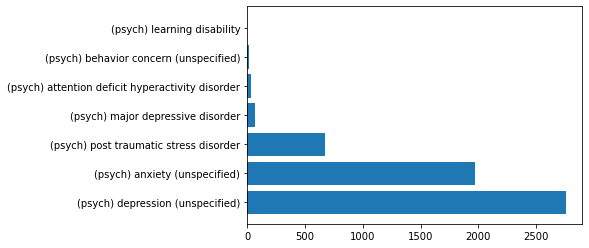

In [17]:
clf = svm.SVC(kernel='linear')
rskf = RepeatedStratifiedKFold(n_splits=23, n_repeats=60, random_state=36851234)

cv_results = cross_validate(clf, psyc_features, psyc_labels, cv=rskf, return_estimator = True,)
sorted(cv_results.keys())

total_svc_coef=np.zeros(np.shape(cv_results['estimator'][0].coef_[0]))
for i in range(len(cv_results['estimator'])):
    total_svc_coef=total_svc_coef+cv_results['estimator'][i].coef_[0]

f_importances(abs(total_svc_coef), indexes, top=7)

# Cross Validation with DNN

In [18]:
def build_and_compile_model(train_features):
    """
    Build and compile a basic 3-layer DNN regression model
    """
    model = keras.Sequential([
        layers.Input(shape=(train_features.shape[1],), name="All_Symptom_Features"),
#         layers.Input(shape=(150,), name="All_Symptom_Features"),

        layers.Dense(train_features.shape[1]*4, activation='relu'),
        layers.Dense(train_features.shape[1]*8, activation='relu'),
#         layers.Dense(train_features.shape[1]/8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

### DNN with ALL Symptoms (Batch Gradient Descent, where Batch Size = Size of Training Set)

In [23]:
skf = StratifiedKFold(n_splits=24,random_state=random.randint(0,300),shuffle=True)

rskf = RepeatedStratifiedKFold(n_splits=23, n_repeats=20, random_state=36851234)

avg_accuracy=0
k=0
for train_index, test_index in rskf.split(all_features, all_labels):
    print(str(k)+"th run")
    print("=====================================")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = all_features[train_index], all_features[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    
    all_symptom_model = build_and_compile_model(X_train)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
    all_history = all_symptom_model.fit(
        X_train, y_train,
        batch_size=X_train.shape[0],
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0, epochs=50)
    loss,accuracy=all_symptom_model.evaluate(X_test, y_test, verbose=0)
    print("Test Accuracy for " + str(k) +"th run:" + str(accuracy*100)+"%")
    avg_accuracy=avg_accuracy+accuracy

    print("=====================================")
    k=k+1

avg_accuracy=avg_accuracy/k
print("Total Score: " + str(avg_accuracy*100)+"%")

0th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [21 25 32]
Test Accuracy for 0th run:66.66666865348816%
1th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 42 43 44 45 46 47] TEST: [ 3 36 41]
Test Accuracy for 1th run:66.66666865348816%
2th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 34]
Test Accuracy for 2th run:50.0%
3th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 33]
Test Accuracy for 3th run:0.0%
4th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [13 2

Test Accuracy for 29th run:100.0%
30th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 34 35 36 37 39 40 41 42 43 44 45 46 47] TEST: [32 38]
Test Accuracy for 30th run:50.0%
31th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 34]
Test Accuracy for 31th run:50.0%
32th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [23 42]
Test Accuracy for 32th run:50.0%
33th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [27 43]
Test Accuracy for 33th run:100.0%
34th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45

Test Accuracy for 59th run:50.0%
60th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [24 47]
Test Accuracy for 60th run:100.0%
61th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [13 17]
Test Accuracy for 61th run:100.0%
62th run
TRAIN: [ 0  1  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [2 4]
Test Accuracy for 62th run:100.0%
63th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [14 34]
Test Accuracy for 63th run:50.0%
64th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 

Test Accuracy for 89th run:0.0%
90th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 34]
Test Accuracy for 90th run:50.0%
91th run
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47] TEST: [ 7 46]
Test Accuracy for 91th run:100.0%
92th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [11 23 31]
Test Accuracy for 92th run:33.33333432674408%
93th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 45 46 47] TEST: [14 42 44]
Test Accuracy for 93th run:33.33333432674408%
94th run
TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37

Test Accuracy for 118th run:100.0%
119th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47] TEST: [12 41]
Test Accuracy for 119th run:0.0%
120th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 8 21]
Test Accuracy for 120th run:100.0%
121th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [11 19]
Test Accuracy for 121th run:50.0%
122th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [ 1 47]
Test Accuracy for 122th run:100.0%
123th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 4

Test Accuracy for 147th run:100.0%
148th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 34 35 36 37 39 40 41 42 43 44 45 46 47] TEST: [32 38]
Test Accuracy for 148th run:50.0%
149th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [12 24]
Test Accuracy for 149th run:100.0%
150th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 31]
Test Accuracy for 150th run:100.0%
151th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 44 45 46 47] TEST: [41 43]
Test Accuracy for 151th run:50.0%
152th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 

Test Accuracy for 176th run:0.0%
177th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [24 36]
Test Accuracy for 177th run:50.0%
178th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [14 42]
Test Accuracy for 178th run:100.0%
179th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 2 25]
Test Accuracy for 179th run:0.0%
180th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 28]
Test Accuracy for 180th run:50.0%
181th run
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 4

Test Accuracy for 205th run:100.0%
206th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47] TEST: [ 0 46]
Test Accuracy for 206th run:50.0%
207th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 36 37 38 39 40 42 43 44 45 46 47] TEST: [30 35 41]
Test Accuracy for 207th run:0.0%
208th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [19 33 43]
Test Accuracy for 208th run:100.0%
209th run
TRAIN: [ 0  1  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [2 8]
Test Accuracy for 209th run:50.0%
210th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 4

Test Accuracy for 234th run:100.0%
235th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47] TEST: [ 8 40]
Test Accuracy for 235th run:100.0%
236th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47] TEST: [13 45]
Test Accuracy for 236th run:100.0%
237th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [18 25]
Test Accuracy for 237th run:100.0%
238th run
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 9 17]
Test Accuracy for 238th run:100.0%
239th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 4

Test Accuracy for 263th run:50.0%
264th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [ 2 42]
Test Accuracy for 264th run:0.0%
265th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47] TEST: [ 0 39]
Test Accuracy for 265th run:50.0%
266th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [15 20]
Test Accuracy for 266th run:50.0%
267th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [23 34]
Test Accuracy for 267th run:50.0%
268th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 4

Test Accuracy for 292th run:50.0%
293th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47] TEST: [15 39]
Test Accuracy for 293th run:100.0%
294th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47] TEST: [31 40]
Test Accuracy for 294th run:50.0%
295th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [12 18]
Test Accuracy for 295th run:100.0%
296th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 29]
Test Accuracy for 296th run:100.0%
297th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 34 35 36 37 39 40 41 

Test Accuracy for 321th run:100.0%
322th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [26 33 36]
Test Accuracy for 322th run:100.0%
323th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 18 32]
Test Accuracy for 323th run:33.33333432674408%
324th run
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 4 22]
Test Accuracy for 324th run:50.0%
325th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 46 47] TEST: [37 45]
Test Accuracy for 325th run:50.0%
326th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 

Test Accuracy for 350th run:100.0%
351th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 47] TEST: [41 46]
Test Accuracy for 351th run:50.0%
352th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 36]
Test Accuracy for 352th run:0.0%
353th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 29]
Test Accuracy for 353th run:50.0%
354th run
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 7 20]
Test Accuracy for 354th run:50.0%
355th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

Test Accuracy for 379th run:50.0%
380th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [21 42]
Test Accuracy for 380th run:100.0%
381th run
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 4 18]
Test Accuracy for 381th run:100.0%
382th run
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 6 36]
Test Accuracy for 382th run:50.0%
383th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47] TEST: [ 8 45]
Test Accuracy for 383th run:50.0%
384th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 4

Test Accuracy for 408th run:50.0%
409th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [24 43]
Test Accuracy for 409th run:100.0%
410th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [ 2 47]
Test Accuracy for 410th run:50.0%
411th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 12]
Test Accuracy for 411th run:50.0%
412th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [23 30]
Test Accuracy for 412th run:100.0%
413th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30 31 32 33 34 35 36 38 39 40 41 4

Test Accuracy for 437th run:66.66666865348816%
438th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [11 16 31]
Test Accuracy for 438th run:33.33333432674408%
439th run
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 5 17]
Test Accuracy for 439th run:50.0%
440th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47] TEST: [21 39]
Test Accuracy for 440th run:100.0%
441th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [27 35]
Test Accuracy for 441th run:50.0%
442th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 

In [75]:
from sklearn.metrics import accuracy_score
#define a score function. In this case I use accuracy
def score(X, y):
    y_pred = all_symptom_model.predict_classes(X)
    return accuracy_score(y, y_pred)


In [76]:
from eli5.permutation_importance import get_score_importances

all_symptom_model = build_and_compile_model(X_train)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
all_history = all_symptom_model.fit(
    X_train, y_train,
    batch_size=X_train.shape[0],
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0, epochs=50)


# all_symptom_model.predict_classes(X_train[34:36])


base_score, score_decreases = get_score_importances(score, X_test, y_test)
feature_importances = np.mean(score_decreases, axis=0)

# my_model = KerasClassifier(build_fn=all_symptom_model)

# my_model.fit(X_train,y_train)


# my_model = KerasRegressor(build_fn=base_model, **sk_params)    
# my_model.fit(X,y)
# base_score, score_decreases = get_score_importances(all_symptom_model, X_test, y_test)
# base_score
# perm = PermutationImportance(all_symptom_model, random_state=1).fit(X_train,y_train, scoring='accuracy')
# eli5.show_weights(perm, feature_names = indexes)


In [77]:
feature_importances

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ,
       0. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

### DNN with ALL Symptoms (Stochastic Gradient Descent, where Batch Size = 1)

In [24]:
skf = StratifiedKFold(n_splits=24,random_state=random.randint(0,300),shuffle=True)

rskf = RepeatedStratifiedKFold(n_splits=23, n_repeats=20, random_state=36851234)

avg_accuracy=0
k=0
for train_index, test_index in rskf.split(all_features, all_labels):
    print(str(k)+"th run")
    print("=====================================")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = all_features[train_index], all_features[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    
    all_symptom_model = build_and_compile_model(X_train)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
    all_history = all_symptom_model.fit(
        X_train, y_train,
        batch_size=1,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0, epochs=50)
    loss,accuracy=all_symptom_model.evaluate(X_test, y_test, verbose=0)
    print("Test Accuracy for " + str(k) +"th run:" + str(accuracy*100)+"%")
    avg_accuracy=avg_accuracy+accuracy

    print("=====================================")
    k=k+1

avg_accuracy=avg_accuracy/k
print("Total Score: " + str(avg_accuracy*100)+"%")

0th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [21 25 32]
Test Accuracy for 0th run:33.33333432674408%
1th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 42 43 44 45 46 47] TEST: [ 3 36 41]
Test Accuracy for 1th run:33.33333432674408%
2th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 34]
Test Accuracy for 2th run:50.0%
3th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 33]
Test Accuracy for 3th run:50.0%
4th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [13 

Test Accuracy for 29th run:100.0%
30th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 34 35 36 37 39 40 41 42 43 44 45 46 47] TEST: [32 38]
Test Accuracy for 30th run:50.0%
31th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 34]
Test Accuracy for 31th run:0.0%
32th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [23 42]
Test Accuracy for 32th run:100.0%
33th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [27 43]
Test Accuracy for 33th run:100.0%
34th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45

Test Accuracy for 59th run:50.0%
60th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [24 47]
Test Accuracy for 60th run:100.0%
61th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [13 17]
Test Accuracy for 61th run:100.0%
62th run
TRAIN: [ 0  1  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [2 4]
Test Accuracy for 62th run:50.0%
63th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [14 34]
Test Accuracy for 63th run:50.0%
64th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 4

Test Accuracy for 89th run:50.0%
90th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 34]
Test Accuracy for 90th run:50.0%
91th run
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47] TEST: [ 7 46]
Test Accuracy for 91th run:100.0%
92th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [11 23 31]
Test Accuracy for 92th run:100.0%
93th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 45 46 47] TEST: [14 42 44]
Test Accuracy for 93th run:33.33333432674408%
94th run
TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 4

Test Accuracy for 119th run:50.0%
120th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 8 21]
Test Accuracy for 120th run:100.0%
121th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [11 19]
Test Accuracy for 121th run:50.0%
122th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [ 1 47]
Test Accuracy for 122th run:50.0%
123th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47] TEST: [16 37]
Test Accuracy for 123th run:50.0%
124th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42

Test Accuracy for 148th run:50.0%
149th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [12 24]
Test Accuracy for 149th run:50.0%
150th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 31]
Test Accuracy for 150th run:50.0%
151th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 44 45 46 47] TEST: [41 43]
Test Accuracy for 151th run:0.0%
152th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [10 42]
Test Accuracy for 152th run:100.0%
153th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

Test Accuracy for 177th run:50.0%
178th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [14 42]
Test Accuracy for 178th run:50.0%
179th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 2 25]
Test Accuracy for 179th run:50.0%
180th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 28]
Test Accuracy for 180th run:50.0%
181th run
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47] TEST: [ 5 40]
Test Accuracy for 181th run:50.0%
182th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 

Test Accuracy for 206th run:50.0%
207th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 36 37 38 39 40 42 43 44 45 46 47] TEST: [30 35 41]
Test Accuracy for 207th run:33.33333432674408%
208th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [19 33 43]
Test Accuracy for 208th run:100.0%
209th run
TRAIN: [ 0  1  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [2 8]
Test Accuracy for 209th run:50.0%
210th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47] TEST: [18 46]
Test Accuracy for 210th run:50.0%
211th run
TRAIN: [ 0  1  2  3  4  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 

Test Accuracy for 235th run:100.0%
236th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47] TEST: [13 45]
Test Accuracy for 236th run:50.0%
237th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [18 25]
Test Accuracy for 237th run:0.0%
238th run
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 9 17]
Test Accuracy for 238th run:100.0%
239th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 32]
Test Accuracy for 239th run:0.0%
240th run
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 

Test Accuracy for 264th run:50.0%
265th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47] TEST: [ 0 39]
Test Accuracy for 265th run:50.0%
266th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [15 20]
Test Accuracy for 266th run:50.0%
267th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [23 34]
Test Accuracy for 267th run:100.0%
268th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [22 43]
Test Accuracy for 268th run:50.0%
269th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42

Test Accuracy for 293th run:100.0%
294th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47] TEST: [31 40]
Test Accuracy for 294th run:50.0%
295th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [12 18]
Test Accuracy for 295th run:100.0%
296th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 29]
Test Accuracy for 296th run:50.0%
297th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 34 35 36 37 39 40 41 42 43 44 45 46 47] TEST: [33 38]
Test Accuracy for 297th run:100.0%
298th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 

Test Accuracy for 322th run:33.33333432674408%
323th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 18 32]
Test Accuracy for 323th run:66.66666865348816%
324th run
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 4 22]
Test Accuracy for 324th run:50.0%
325th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 46 47] TEST: [37 45]
Test Accuracy for 325th run:50.0%
326th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 8 16]
Test Accuracy for 326th run:50.0%
327th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 3

Test Accuracy for 351th run:50.0%
352th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 36]
Test Accuracy for 352th run:0.0%
353th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 29]
Test Accuracy for 353th run:100.0%
354th run
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 7 20]
Test Accuracy for 354th run:50.0%
355th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 17]
Test Accuracy for 355th run:100.0%
356th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42

Test Accuracy for 380th run:100.0%
381th run
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 4 18]
Test Accuracy for 381th run:50.0%
382th run
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 6 36]
Test Accuracy for 382th run:50.0%
383th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47] TEST: [ 8 45]
Test Accuracy for 383th run:50.0%
384th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 2 11]
Test Accuracy for 384th run:50.0%
385th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37 39 40 41 42

Test Accuracy for 409th run:100.0%
410th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [ 2 47]
Test Accuracy for 410th run:50.0%
411th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 12]
Test Accuracy for 411th run:50.0%
412th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [23 30]
Test Accuracy for 412th run:50.0%
413th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47] TEST: [28 37]
Test Accuracy for 413th run:50.0%
414th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 20 21 22 23 24 25
 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43

Test Accuracy for 438th run:33.33333432674408%
439th run
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 5 17]
Test Accuracy for 439th run:50.0%
440th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47] TEST: [21 39]
Test Accuracy for 440th run:100.0%
441th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [27 35]
Test Accuracy for 441th run:50.0%
442th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47] TEST: [ 3 45]
Test Accuracy for 442th run:50.0%
443th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 3

In [26]:
def build_and_compile_model(train_features):
    """
    Build and compile a basic 3-layer DNN regression model
    """
    model = keras.Sequential([
        layers.Input(shape=(train_features.shape[1],), name="All_Symptom_Features"),
#         layers.Input(shape=(150,), name="All_Symptom_Features"),

        layers.Dense(train_features.shape[1]*4, activation='relu'),
#         layers.Dense(train_features.shape[1]*8, activation='relu'),
#         layers.Dense(train_features.shape[1]*8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


skf = StratifiedKFold(n_splits=24,random_state=random.randint(0,300),shuffle=True)

rskf = RepeatedStratifiedKFold(n_splits=23, n_repeats=20, random_state=36851234)

avg_accuracy=0
k=0
for train_index, test_index in rskf.split(all_features, all_labels):
    print(str(k)+"th run")
    print("=====================================")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = all_features[train_index], all_features[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    
    all_symptom_model = build_and_compile_model(X_train)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
    all_history = all_symptom_model.fit(
        X_train, y_train,
        batch_size=X_train.shape[0],
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0, epochs=50)
    loss,accuracy=all_symptom_model.evaluate(X_test, y_test, verbose=0)
    print("Test Accuracy for " + str(k) +"th run:" + str(accuracy*100)+"%")
    avg_accuracy=avg_accuracy+accuracy

    print("=====================================")
    k=k+1

avg_accuracy=avg_accuracy/k
print("Total Score: " + str(avg_accuracy*100)+"%")

0th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [21 25 32]
Test Accuracy for 0th run:66.66666865348816%
1th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 42 43 44 45 46 47] TEST: [ 3 36 41]
Test Accuracy for 1th run:100.0%
2th run
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 1 34]
Test Accuracy for 2th run:0.0%
3th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 33]
Test Accuracy for 3th run:100.0%
4th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [13 28]
Test Acc

Test Accuracy for 24th run:66.66666865348816%
25th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [19 33]
Test Accuracy for 25th run:100.0%
26th run
TRAIN: [ 0  1  2  3  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [4 7]
Test Accuracy for 26th run:100.0%
27th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 2 12]
Test Accuracy for 27th run:50.0%
28th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 45 46 47] TEST: [40 44]
Test Accuracy for 28th run:50.0%
29th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 

Test Accuracy for 54th run:100.0%
55th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47] TEST: [23 37]
Test Accuracy for 55th run:100.0%
56th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [26 42]
Test Accuracy for 56th run:100.0%
57th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47] TEST: [12 45]
Test Accuracy for 57th run:50.0%
58th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [22 36]
Test Accuracy for 58th run:0.0%
59th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45

Test Accuracy for 84th run:50.0%
85th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [27 42]
Test Accuracy for 85th run:100.0%
86th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47] TEST: [ 2 37]
Test Accuracy for 86th run:50.0%
87th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [25 26]
Test Accuracy for 87th run:100.0%
88th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 8 18]
Test Accuracy for 88th run:100.0%
89th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 4

Test Accuracy for 114th run:50.0%
115th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 47] TEST: [22 35 46]
Test Accuracy for 115th run:33.33333432674408%
116th run
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [ 6 31 43]
Test Accuracy for 116th run:33.33333432674408%
117th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47] TEST: [23 36]
Test Accuracy for 117th run:50.0%
118th run
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 9 27]
Test Accuracy for 118th run:100.0%
119th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 

Test Accuracy for 143th run:50.0%
144th run
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 7 11]
Test Accuracy for 144th run:50.0%
145th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [19 35]
Test Accuracy for 145th run:50.0%
146th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [18 47]
Test Accuracy for 146th run:100.0%
147th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [25 26]
Test Accuracy for 147th run:100.0%
148th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 34 35 36 37 39 40 41 4

Test Accuracy for 172th run:100.0%
173th run
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 4 18]
Test Accuracy for 173th run:100.0%
174th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47] TEST: [26 44]
Test Accuracy for 174th run:50.0%
175th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [21 29]
Test Accuracy for 175th run:100.0%
176th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [22 32]
Test Accuracy for 176th run:0.0%
177th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 4

Test Accuracy for 201th run:50.0%
202th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 8 21]
Test Accuracy for 202th run:100.0%
203th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47] TEST: [15 43]
Test Accuracy for 203th run:100.0%
204th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [11 23]
Test Accuracy for 204th run:50.0%
205th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [18 31]
Test Accuracy for 205th run:50.0%
206th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 4

Test Accuracy for 230th run:66.66666865348816%
231th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [12 14 31]
Test Accuracy for 231th run:66.66666865348816%
232th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47] TEST: [23 37]
Test Accuracy for 232th run:100.0%
233th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [21 47]
Test Accuracy for 233th run:100.0%
234th run
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [3 6]
Test Accuracy for 234th run:100.0%
235th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 

Test Accuracy for 259th run:0.0%
260th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47] TEST: [19 44]
Test Accuracy for 260th run:50.0%
261th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 21]
Test Accuracy for 261th run:100.0%
262th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [24 31]
Test Accuracy for 262th run:100.0%
263th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47] TEST: [30 40]
Test Accuracy for 263th run:100.0%
264th run
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 4

Test Accuracy for 288th run:50.0%
289th run
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 6 35]
Test Accuracy for 289th run:50.0%
290th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [17 47]
Test Accuracy for 290th run:100.0%
291th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47] TEST: [27 46]
Test Accuracy for 291th run:100.0%
292th run
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 8 22]
Test Accuracy for 292th run:50.0%
293th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 4

Test Accuracy for 317th run:50.0%
318th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [15 31]
Test Accuracy for 318th run:100.0%
319th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 13]
Test Accuracy for 319th run:100.0%
320th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47] TEST: [29 41]
Test Accuracy for 320th run:50.0%
321th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 17]
Test Accuracy for 321th run:100.0%
322th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31 32 34 35 37 38 39 40 41 42 

Test Accuracy for 346th run:66.66666865348816%
347th run
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47] TEST: [ 6 39]
Test Accuracy for 347th run:100.0%
348th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35 36 37 39 40 41 42 43 44 45 46 47] TEST: [30 38]
Test Accuracy for 348th run:50.0%
349th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47] TEST: [14 44]
Test Accuracy for 349th run:50.0%
350th run
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 4 23]
Test Accuracy for 350th run:100.0%
351th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 

Test Accuracy for 375th run:50.0%
376th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 29]
Test Accuracy for 376th run:100.0%
377th run
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 3 28]
Test Accuracy for 377th run:50.0%
378th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [ 0 25]
Test Accuracy for 378th run:50.0%
379th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [20 24]
Test Accuracy for 379th run:50.0%
380th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41

Test Accuracy for 404th run:100.0%
405th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [10 33]
Test Accuracy for 405th run:50.0%
406th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47] TEST: [21 39]
Test Accuracy for 406th run:100.0%
407th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47] TEST: [32 40]
Test Accuracy for 407th run:50.0%
408th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47] TEST: [29 45]
Test Accuracy for 408th run:50.0%
409th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 4

Test Accuracy for 433th run:100.0%
434th run
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47] TEST: [ 0 42]
Test Accuracy for 434th run:50.0%
435th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 37 38 39 41 42 43 44 45 46 47] TEST: [36 40]
Test Accuracy for 435th run:100.0%
436th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 34 35 36 37 39 40 41 42 43 44 45 46 47] TEST: [32 38]
Test Accuracy for 436th run:50.0%
437th run
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 45 46 47] TEST: [ 7 34 44]
Test Accuracy for 437th run:33.33333432674408%
438th run
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 32 33 34 35 36 37 38 

In [27]:

import shap

# load your data here, e.g. X and y
# create and fit your model here

# load JS visualization code to notebook
shap.initjs()


In [5]:
    random_state=random.randint(0,300)


In [6]:
#real one...?

def stratifyTrainTestSplit(X,y,random_state):
    stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)

    stratSplit.get_n_splits(X, y)
    for train_index, test_index in stratSplit.split(X,y):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return (X_train, X_test, y_train, y_test)

In [53]:
all_features_train,all_features_test,all_labels_train,all_labels_test=stratifyTrainTestSplit(all_features,all_labels,random.randint(0,300))

print(all_features_train.shape)
print(all_labels_train.shape)
print(all_features_test.shape)
print(all_labels_test.shape)
print(all_features_train)

(38, 51)
(38,)
(10, 51)
(10,)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Build, Compile, Visualize Model

In [ ]:
def identify_optimal_hyperparameters():
    for i in range(4):
        for j in range(4):
            avg_accuracy=repeat_train_test(i,j)
            

In [58]:
def build_and_compile_model(train_features):
    """
    Build and compile a basic 3-layer DNN regression model
    """
    model = keras.Sequential([
        layers.Input(shape=(train_features.shape[1],), name="All_Symptom_Features"),
#         layers.Input(shape=(150,), name="All_Symptom_Features"),

        layers.Dense(train_features.shape[1]*4, activation='relu'),
        layers.Dense(train_features.shape[1]*8, activation='relu'),
#         layers.Dense(train_features.shape[1]/8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

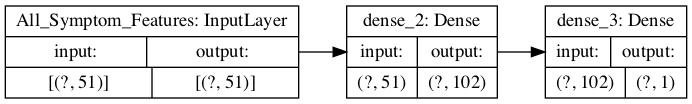

In [15]:
all_symptom_model = build_and_compile_model(all_features_train)
plot_model(
    all_symptom_model, to_file='./all_symptom_dnn_model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

### Train Model

In [16]:
# %%time
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
all_history = all_symptom_model.fit(
    all_features_train, all_labels_train,
#     batch_size=128,
    batch_size=38,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1, epochs=50)

Epoch 1/50
1/1 [==============================] - 0s 160ms/step - loss: 0.6743 - accuracy: 0.5333 - val_loss: 0.6817 - val_accuracy: 0.6250
Epoch 2/50
1/1 [==============================] - 0s 19ms/step - loss: 0.6650 - accuracy: 0.5667 - val_loss: 0.6779 - val_accuracy: 0.6250
Epoch 3/50
1/1 [==============================] - 0s 32ms/step - loss: 0.6559 - accuracy: 0.6333 - val_loss: 0.6741 - val_accuracy: 0.6250
Epoch 4/50
1/1 [==============================] - 0s 37ms/step - loss: 0.6469 - accuracy: 0.6667 - val_loss: 0.6704 - val_accuracy: 0.6250
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.6381 - accuracy: 0.8333 - val_loss: 0.6668 - val_accuracy: 0.6250
Epoch 6/50
1/1 [==============================] - 0s 34ms/step - loss: 0.6293 - accuracy: 0.8667 - val_loss: 0.6633 - val_accuracy: 0.6250
Epoch 7/50
1/1 [==============================] - 0s 19ms/step - loss: 0.6207 - accuracy: 0.9000 - val_loss: 0.6598 - val_accuracy: 0.6250
Epoch 8/50
1/1 [==========

In [18]:
def plot_loss(history, title, save=False, fname=None):
    """
    Show the model's loss on training and validation data for each training epoch in the training trial
    """
    plt.title(title)
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylim([0, 20])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SPS]')
    plt.legend()
    plt.grid(True)
    
    if save:
        if fname is None:
            fname = './history.png'
        
        plt.savefig(fname)

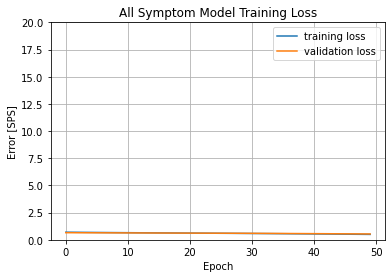

In [53]:
# Check Training History
plot_loss(history=all_history, 
          title='All Symptom Model Training Loss', 
          save=True, 
          fname='./200_dnn_training.png')

### Test all-symptoms model

In [17]:
all_loss,all_accuracy=all_symptom_model.evaluate(all_features_test, all_labels_test, verbose=0)
print("Test Accuracy:" + str(all_accuracy*100)+"%")

Test Accuracy:40.00000059604645%


### Repeat Train/Test

In [59]:
avg_accuracy=0

for i in range(500):
    all_features_train,all_features_test,all_labels_train,all_labels_test=stratifyTrainTestSplit(all_features,all_labels,random.randint(0,3000))
    all_symptom_model = build_and_compile_model(all_features_train)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
    all_history = all_symptom_model.fit(
        all_features_train, all_labels_train,
        batch_size=38,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0, epochs=50)
    all_loss,all_accuracy=all_symptom_model.evaluate(all_features_test, all_labels_test, verbose=0)

    print("Test Accuracy for " + str(i) +"th run:" + str(all_accuracy*100)+"%")
    avg_accuracy=avg_accuracy+all_accuracy

print("Average accuracy is " + str(avg_accuracy/500))        

Test Accuracy for 0th run:50.0%
Test Accuracy for 1th run:80.0000011920929%
Test Accuracy for 2th run:60.00000238418579%
Test Accuracy for 3th run:69.9999988079071%
Test Accuracy for 4th run:60.00000238418579%
Test Accuracy for 5th run:50.0%
Test Accuracy for 6th run:80.0000011920929%
Test Accuracy for 7th run:50.0%
Test Accuracy for 8th run:69.9999988079071%
Test Accuracy for 9th run:80.0000011920929%
Test Accuracy for 10th run:60.00000238418579%
Test Accuracy for 11th run:60.00000238418579%
Test Accuracy for 12th run:60.00000238418579%
Test Accuracy for 13th run:60.00000238418579%
Test Accuracy for 14th run:69.9999988079071%
Test Accuracy for 15th run:69.9999988079071%
Test Accuracy for 16th run:69.9999988079071%
Test Accuracy for 17th run:40.00000059604645%
Test Accuracy for 18th run:60.00000238418579%
Test Accuracy for 19th run:80.0000011920929%
Test Accuracy for 20th run:69.9999988079071%
Test Accuracy for 21th run:50.0%
Test Accuracy for 22th run:50.0%
Test Accuracy for 23th run:

Test Accuracy for 190th run:69.9999988079071%
Test Accuracy for 191th run:50.0%
Test Accuracy for 192th run:60.00000238418579%
Test Accuracy for 193th run:80.0000011920929%
Test Accuracy for 194th run:69.9999988079071%
Test Accuracy for 195th run:60.00000238418579%
Test Accuracy for 196th run:80.0000011920929%
Test Accuracy for 197th run:69.9999988079071%
Test Accuracy for 198th run:89.99999761581421%
Test Accuracy for 199th run:60.00000238418579%
Test Accuracy for 200th run:40.00000059604645%
Test Accuracy for 201th run:60.00000238418579%
Test Accuracy for 202th run:30.000001192092896%
Test Accuracy for 203th run:50.0%
Test Accuracy for 204th run:40.00000059604645%
Test Accuracy for 205th run:100.0%
Test Accuracy for 206th run:89.99999761581421%
Test Accuracy for 207th run:69.9999988079071%
Test Accuracy for 208th run:69.9999988079071%
Test Accuracy for 209th run:60.00000238418579%
Test Accuracy for 210th run:60.00000238418579%
Test Accuracy for 211th run:69.9999988079071%
Test Accura

Test Accuracy for 378th run:50.0%
Test Accuracy for 379th run:30.000001192092896%
Test Accuracy for 380th run:30.000001192092896%
Test Accuracy for 381th run:69.9999988079071%
Test Accuracy for 382th run:50.0%
Test Accuracy for 383th run:80.0000011920929%
Test Accuracy for 384th run:69.9999988079071%
Test Accuracy for 385th run:60.00000238418579%
Test Accuracy for 386th run:80.0000011920929%
Test Accuracy for 387th run:40.00000059604645%
Test Accuracy for 388th run:50.0%
Test Accuracy for 389th run:80.0000011920929%
Test Accuracy for 390th run:60.00000238418579%
Test Accuracy for 391th run:60.00000238418579%
Test Accuracy for 392th run:80.0000011920929%
Test Accuracy for 393th run:60.00000238418579%
Test Accuracy for 394th run:40.00000059604645%
Test Accuracy for 395th run:69.9999988079071%
Test Accuracy for 396th run:20.000000298023224%
Test Accuracy for 397th run:69.9999988079071%
Test Accuracy for 398th run:69.9999988079071%
Test Accuracy for 399th run:80.0000011920929%
Test Accurac

# Psyc-Only Model

In [19]:
psyc_df=df.copy()
psyc_df.drop(psyc_df.index[7:-1], inplace=True)
psyc_df

,Past medical history item,1,2,3,7,8,9,10,11,12,...,46,47,48,49,50,51,52,53,54,55
4,(psych) anxiety (unspecified),0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,(psych) attention deficit hyperactivity disorder,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,(psych) behavior concern (unspecified),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,(psych) depression (unspecified),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,(psych) learning disability,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,(psych) major depressive disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
24,(psych) post traumatic stress disorder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328,isStiff,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
#get rid of medical terms and separate features and labels
psyc_np=psyc_df.to_numpy().transpose()[1:].transpose()
psyc_np = np.asarray(psyc_np).astype('float32')

psyc_features=psyc_np[0:-1].transpose()
psyc_labels=psyc_np[-1].transpose()

print(psyc_features.shape)
print(psyc_features)

print(psyc_labels.shape)
print(psyc_labels)

(48, 7)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 

### Train-Test Split of psyc data

In [21]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

stratSplit.get_n_splits(psyc_features, psyc_labels)

for train_index, test_index in stratSplit.split(psyc_features,psyc_labels):
    print("TRAIN:", train_index, "TEST:", test_index)
    psyc_train_features, psyc_test_features = psyc_features[train_index], psyc_features[test_index]
    psyc_train_labels, psyc_test_labels = psyc_labels[train_index], psyc_labels[test_index]

print(psyc_train_features.shape)
print(psyc_test_features.shape)
print(psyc_train_labels.shape)
print(psyc_test_labels.shape)

TRAIN: [13 18 20  9  0 14 32  2 21 24 19 23 35 12 42 47 15  5 28 33 10 37 25 27
 46 36 44 22 30  1 11 39 41 29  7  4 45  6] TEST: [ 3 43 26  8 17 34 40 16 38 31]
(38, 7)
(10, 7)
(38,)
(10,)


In [26]:
psyc_test_labels

array([0., 0., 1., 0., 1., 0., 1., 1., 1., 0.], dtype=float32)

### Build and compile Psyc-Only Model

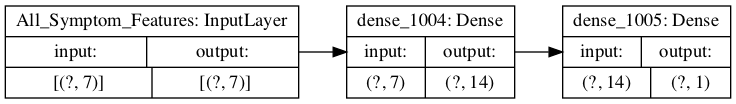

In [22]:
psyc_symptom_model = build_and_compile_model(psyc_train_features)
plot_model(
    psyc_symptom_model, to_file='./all_symptom_dnn_model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

### Train Psyc-Only Model

Epoch 1/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6451 - accuracy: 0.6667 - val_loss: 0.7734 - val_accuracy: 0.3750
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6667 - val_loss: 0.7730 - val_accuracy: 0.3750
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6667 - val_loss: 0.7721 - val_accuracy: 0.3750
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6667 - val_loss: 0.7715 - val_accuracy: 0.3750
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6667 - val_loss: 0.7712 - val_accuracy: 0.3750
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6667 - val_loss: 0.7704 - val_accuracy: 0.3750
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6667 - val_loss: 0.7697 - val_accuracy: 0.3750
Epoch 8/50
30/30 [=

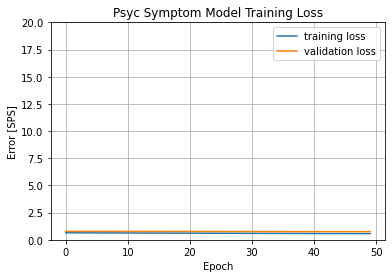

In [28]:
# %%time
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
psyc_history = psyc_symptom_model.fit(
    psyc_train_features, psyc_train_labels,
    batch_size=1,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1, epochs=50)

# Check Training History
plot_loss(history=psyc_history, 
          title='Psyc Symptom Model Training Loss', 
          save=True, 
          fname='./200_dnn_training.png')

### Test Psyc-Only Model

In [29]:
loss,psyc_accuracy=psyc_symptom_model.evaluate(psyc_test_features, psyc_test_labels, verbose=0)
print("Test Accuracy:" + str(psyc_accuracy*100)+"%")

Test Accuracy:69.9999988079071%


### Repeat Train/Test

In [24]:
psyc_avg_accuracy=0

for i in range(500):
    psyc_features_train,psyc_features_test,psyc_labels_train,psyc_labels_test=stratifyTrainTestSplit(psyc_features,psyc_labels,random.randint(0,3000))
    psyc_symptom_model = build_and_compile_model(psyc_features_train)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
    psyc_history = psyc_symptom_model.fit(
        psyc_features_train, psyc_labels_train,
        batch_size=38,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0, epochs=50)
    psyc_loss,psyc_accuracy=psyc_symptom_model.evaluate(psyc_features_test, psyc_labels_test, verbose=0)
    print("=================================================")
    print("Test Accuracy for " + str(i) +"th run:" + str(psyc_accuracy*100)+"%")
    print("=================================================")
    psyc_avg_accuracy=psyc_avg_accuracy+psyc_accuracy

print("=================================================")
print("Average Accuracy:" + str((psyc_avg_accuracy/500)*100)+"%")


Test Accuracy for 0th run:69.9999988079071%
Test Accuracy for 1th run:69.9999988079071%
Test Accuracy for 2th run:40.00000059604645%
Test Accuracy for 3th run:60.00000238418579%
Test Accuracy for 4th run:60.00000238418579%
Test Accuracy for 5th run:89.99999761581421%
Test Accuracy for 6th run:40.00000059604645%
Test Accuracy for 7th run:69.9999988079071%
Test Accuracy for 8th run:20.000000298023224%
Test Accuracy for 9th run:50.0%
Test Accuracy for 10th run:80.0000011920929%
Test Accuracy for 11th run:69.9999988079071%
Test Accuracy for 12th run:50.0%
Test Accuracy for 13th run:40.00000059604645%
Test Accuracy for 14th run:50.0%
Test Accuracy for 15th run:20.000000298023224%
Test Accuracy for 16th run:50.0%
Test Accuracy for 17th run:69.9999988079071%
Test Accuracy for 18th run:69.9999988079071%
Test Accuracy for 19th run:50.0%
Test Accuracy for 20th run:40.00000059604645%
Test Accuracy for 21th run:69.9999988079071%
Test Accuracy for 22th run:60.00000238418579%
Test Accuracy for 23th 

Test Accuracy for 58th run:50.0%
Test Accuracy for 59th run:50.0%
Test Accuracy for 60th run:60.00000238418579%
Test Accuracy for 61th run:69.9999988079071%
Test Accuracy for 62th run:60.00000238418579%
Test Accuracy for 63th run:50.0%
Test Accuracy for 64th run:50.0%
Test Accuracy for 65th run:69.9999988079071%
Test Accuracy for 66th run:69.9999988079071%
Test Accuracy for 67th run:40.00000059604645%
Test Accuracy for 68th run:40.00000059604645%
Test Accuracy for 69th run:40.00000059604645%
Test Accuracy for 70th run:69.9999988079071%
Test Accuracy for 71th run:50.0%
Test Accuracy for 72th run:50.0%
Test Accuracy for 73th run:40.00000059604645%
Test Accuracy for 74th run:50.0%
Test Accuracy for 75th run:60.00000238418579%
Test Accuracy for 76th run:60.00000238418579%
Test Accuracy for 77th run:40.00000059604645%
Test Accuracy for 78th run:60.00000238418579%
Test Accuracy for 79th run:40.00000059604645%
Test Accuracy for 80th run:69.9999988079071%
Test Accuracy for 81th run:40.00000059

Test Accuracy for 116th run:60.00000238418579%
Test Accuracy for 117th run:40.00000059604645%
Test Accuracy for 118th run:40.00000059604645%
Test Accuracy for 119th run:69.9999988079071%
Test Accuracy for 120th run:50.0%
Test Accuracy for 121th run:40.00000059604645%
Test Accuracy for 122th run:60.00000238418579%
Test Accuracy for 123th run:69.9999988079071%
Test Accuracy for 124th run:60.00000238418579%
Test Accuracy for 125th run:50.0%
Test Accuracy for 126th run:50.0%
Test Accuracy for 127th run:50.0%
Test Accuracy for 128th run:60.00000238418579%
Test Accuracy for 129th run:69.9999988079071%
Test Accuracy for 130th run:60.00000238418579%
Test Accuracy for 131th run:40.00000059604645%
Test Accuracy for 132th run:40.00000059604645%
Test Accuracy for 133th run:30.000001192092896%
Test Accuracy for 134th run:80.0000011920929%
Test Accuracy for 135th run:60.00000238418579%
Test Accuracy for 136th run:50.0%
Test Accuracy for 137th run:20.000000298023224%
Test Accuracy for 138th run:69.99

Test Accuracy for 173th run:40.00000059604645%
Test Accuracy for 174th run:30.000001192092896%
Test Accuracy for 175th run:40.00000059604645%
Test Accuracy for 176th run:40.00000059604645%
Test Accuracy for 177th run:60.00000238418579%
Test Accuracy for 178th run:50.0%
Test Accuracy for 179th run:69.9999988079071%
Test Accuracy for 180th run:50.0%
Test Accuracy for 181th run:69.9999988079071%
Test Accuracy for 182th run:69.9999988079071%
Test Accuracy for 183th run:40.00000059604645%
Test Accuracy for 184th run:50.0%
Test Accuracy for 185th run:60.00000238418579%
Test Accuracy for 186th run:50.0%
Test Accuracy for 187th run:50.0%
Test Accuracy for 188th run:50.0%
Test Accuracy for 189th run:60.00000238418579%
Test Accuracy for 190th run:40.00000059604645%
Test Accuracy for 191th run:60.00000238418579%
Test Accuracy for 192th run:69.9999988079071%
Test Accuracy for 193th run:80.0000011920929%
Test Accuracy for 194th run:60.00000238418579%
Test Accuracy for 195th run:60.00000238418579%
T

Test Accuracy for 231th run:50.0%
Test Accuracy for 232th run:40.00000059604645%
Test Accuracy for 233th run:30.000001192092896%
Test Accuracy for 234th run:30.000001192092896%
Test Accuracy for 235th run:69.9999988079071%
Test Accuracy for 236th run:40.00000059604645%
Test Accuracy for 237th run:69.9999988079071%
Test Accuracy for 238th run:50.0%
Test Accuracy for 239th run:69.9999988079071%
Test Accuracy for 240th run:69.9999988079071%
Test Accuracy for 241th run:60.00000238418579%
Test Accuracy for 242th run:60.00000238418579%
Test Accuracy for 243th run:50.0%
Test Accuracy for 244th run:60.00000238418579%
Test Accuracy for 245th run:60.00000238418579%
Test Accuracy for 246th run:50.0%
Test Accuracy for 247th run:50.0%
Test Accuracy for 248th run:60.00000238418579%
Test Accuracy for 249th run:50.0%
Test Accuracy for 250th run:50.0%
Test Accuracy for 251th run:30.000001192092896%
Test Accuracy for 252th run:50.0%
Test Accuracy for 253th run:60.00000238418579%
Test Accuracy for 254th 

Test Accuracy for 289th run:50.0%
Test Accuracy for 290th run:69.9999988079071%
Test Accuracy for 291th run:69.9999988079071%
Test Accuracy for 292th run:69.9999988079071%
Test Accuracy for 293th run:40.00000059604645%
Test Accuracy for 294th run:50.0%
Test Accuracy for 295th run:60.00000238418579%
Test Accuracy for 296th run:50.0%
Test Accuracy for 297th run:69.9999988079071%
Test Accuracy for 298th run:60.00000238418579%
Test Accuracy for 299th run:69.9999988079071%
Test Accuracy for 300th run:30.000001192092896%
Test Accuracy for 301th run:60.00000238418579%
Test Accuracy for 302th run:30.000001192092896%
Test Accuracy for 303th run:50.0%
Test Accuracy for 304th run:40.00000059604645%
Test Accuracy for 305th run:50.0%
Test Accuracy for 306th run:60.00000238418579%
Test Accuracy for 307th run:60.00000238418579%
Test Accuracy for 308th run:50.0%
Test Accuracy for 309th run:50.0%
Test Accuracy for 310th run:69.9999988079071%
Test Accuracy for 311th run:69.9999988079071%
Test Accuracy f

Test Accuracy for 347th run:50.0%
Test Accuracy for 348th run:60.00000238418579%
Test Accuracy for 349th run:50.0%
Test Accuracy for 350th run:69.9999988079071%
Test Accuracy for 351th run:30.000001192092896%
Test Accuracy for 352th run:60.00000238418579%
Test Accuracy for 353th run:40.00000059604645%
Test Accuracy for 354th run:69.9999988079071%
Test Accuracy for 355th run:40.00000059604645%
Test Accuracy for 356th run:50.0%
Test Accuracy for 357th run:60.00000238418579%
Test Accuracy for 358th run:50.0%
Test Accuracy for 359th run:69.9999988079071%
Test Accuracy for 360th run:30.000001192092896%
Test Accuracy for 361th run:40.00000059604645%
Test Accuracy for 362th run:50.0%
Test Accuracy for 363th run:69.9999988079071%
Test Accuracy for 364th run:30.000001192092896%
Test Accuracy for 365th run:50.0%
Test Accuracy for 366th run:50.0%
Test Accuracy for 367th run:50.0%
Test Accuracy for 368th run:80.0000011920929%
Test Accuracy for 369th run:40.00000059604645%
Test Accuracy for 370th r

Test Accuracy for 405th run:50.0%
Test Accuracy for 406th run:89.99999761581421%
Test Accuracy for 407th run:80.0000011920929%
Test Accuracy for 408th run:40.00000059604645%
Test Accuracy for 409th run:40.00000059604645%
Test Accuracy for 410th run:60.00000238418579%
Test Accuracy for 411th run:30.000001192092896%
Test Accuracy for 412th run:50.0%
Test Accuracy for 413th run:60.00000238418579%
Test Accuracy for 414th run:60.00000238418579%
Test Accuracy for 415th run:30.000001192092896%
Test Accuracy for 416th run:60.00000238418579%
Test Accuracy for 417th run:50.0%
Test Accuracy for 418th run:40.00000059604645%
Test Accuracy for 419th run:30.000001192092896%
Test Accuracy for 420th run:50.0%
Test Accuracy for 421th run:40.00000059604645%
Test Accuracy for 422th run:50.0%
Test Accuracy for 423th run:40.00000059604645%
Test Accuracy for 424th run:50.0%
Test Accuracy for 425th run:60.00000238418579%
Test Accuracy for 426th run:50.0%
Test Accuracy for 427th run:50.0%
Test Accuracy for 428

Test Accuracy for 463th run:50.0%
Test Accuracy for 464th run:50.0%
Test Accuracy for 465th run:69.9999988079071%
Test Accuracy for 466th run:50.0%
Test Accuracy for 467th run:60.00000238418579%
Test Accuracy for 468th run:50.0%
Test Accuracy for 469th run:40.00000059604645%
Test Accuracy for 470th run:20.000000298023224%
Test Accuracy for 471th run:69.9999988079071%
Test Accuracy for 472th run:60.00000238418579%
Test Accuracy for 473th run:50.0%
Test Accuracy for 474th run:69.9999988079071%
Test Accuracy for 475th run:50.0%
Test Accuracy for 476th run:40.00000059604645%
Test Accuracy for 477th run:40.00000059604645%
Test Accuracy for 478th run:60.00000238418579%
Test Accuracy for 479th run:50.0%
Test Accuracy for 480th run:60.00000238418579%
Test Accuracy for 481th run:60.00000238418579%
Test Accuracy for 482th run:50.0%
Test Accuracy for 483th run:60.00000238418579%
Test Accuracy for 484th run:40.00000059604645%
Test Accuracy for 485th run:50.0%
Test Accuracy for 486th run:60.0000023

# Non-Psyc Model

In [43]:
rest_df=df.copy()
rest_df.drop(rest_df.index[0:7], inplace=True)
rest_df

,Past medical history item,1,2,3,7,8,9,10,11,12,...,46,47,48,49,50,51,52,53,54,55
32,abnormal involuntary movement,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,amblyopia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
46,"anemia, iron deficiency",0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,asthma,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
55,atherosclerotic cardiovascular disease,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,carpal tunnel syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,cognitive impairment,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
82,colon polyps,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,diabetes mellitus (unspecified),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,"diabetes mellitus, type 1",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#get rid of medical terms and separate features and labels
rest_np=rest_df.to_numpy().transpose()[1:].transpose()
rest_np = np.asarray(rest_np).astype('float32')

rest_features=rest_np[0:-1].transpose()
rest_labels=rest_np[-1].transpose()

print(rest_features.shape)
print(rest_features)

print(rest_labels.shape)
print(rest_labels)

(48, 44)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(48,)
[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]


### Train-Test Split

In [46]:
random_state = 101

rest_train_features, rest_test_features, rest_train_labels, rest_test_labels = train_test_split(rest_features, rest_labels, test_size=0.2, random_state=random_state)

print(rest_train_features.shape)
print(rest_test_features.shape)
print(rest_train_labels.shape)
print(rest_test_labels.shape)


(38, 44)
(10, 44)
(38,)
(10,)


### Create and compile model

In [37]:
rest_symptom_model = build_and_compile_model(rest_train_features)
plot_model(
    rest_symptom_model, to_file='./all_symptom_dnn_model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

NameError: name 'rest_train_features' is not defined

Epoch 1/50
1/1 [==============================] - 0s 159ms/step - loss: 0.7102 - accuracy: 0.4333 - val_loss: 0.6645 - val_accuracy: 0.3750
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.6665 - accuracy: 0.5000 - val_loss: 0.6612 - val_accuracy: 0.8750
Epoch 3/50
1/1 [==============================] - 0s 75ms/step - loss: 0.6292 - accuracy: 0.7333 - val_loss: 0.6580 - val_accuracy: 0.8750
Epoch 4/50
1/1 [==============================] - 0s 54ms/step - loss: 0.5970 - accuracy: 0.9000 - val_loss: 0.6550 - val_accuracy: 0.8750
Epoch 5/50
1/1 [==============================] - 0s 101ms/step - loss: 0.5693 - accuracy: 0.9000 - val_loss: 0.6518 - val_accuracy: 0.8750
Epoch 6/50
1/1 [==============================] - 0s 125ms/step - loss: 0.5442 - accuracy: 0.9000 - val_loss: 0.6483 - val_accuracy: 0.8750
Epoch 7/50
1/1 [==============================] - 0s 80ms/step - loss: 0.5207 - accuracy: 0.9000 - val_loss: 0.6445 - val_accuracy: 0.8750
Epoch 8/50
1/1 [========

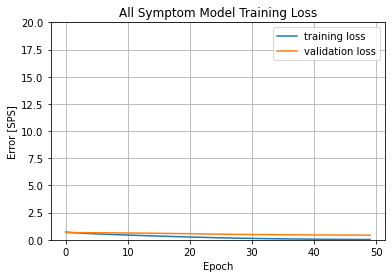

In [319]:
# %%time
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
rest_history = rest_symptom_model.fit(
    rest_train_features, rest_train_labels,
    batch_size=38,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1, epochs=50)

# Check Training History
plot_loss(history=rest_history, 
          title='All Symptom Model Training Loss', 
          save=True, 
          fname='./200_dnn_training.png')

### Test Model

In [321]:
rest_loss,rest_accuracy=rest_symptom_model.evaluate(rest_test_features, rest_test_labels, verbose=0)
print("Test Accuracy:" + str(rest_accuracy*100)+"%")

Test Accuracy:50.0%


### Repeat Train Test Split

In [47]:
rest_avg_accuracy=0

for i in range(500):
    rest_features_train,rest_features_test,rest_labels_train,rest_labels_test=stratifyTrainTestSplit(rest_features,rest_labels,random.randint(0,300))
    rest_symptom_model = build_and_compile_model(rest_features_train)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
    rest_history = rest_symptom_model.fit(
        rest_features_train, rest_labels_train,
        batch_size=38,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0, epochs=50)
    rest_loss,rest_accuracy=rest_symptom_model.evaluate(rest_features_test, rest_labels_test, verbose=0)
    print("=================================================")
    print("Test Accuracy for " + str(i) +"th run:" + str(rest_accuracy*100)+"%")
    print("=================================================")
    rest_avg_accuracy=rest_avg_accuracy+rest_accuracy

print("=================================================")
print("Average Accuracy:" + str((rest_avg_accuracy/500)*100)+"%")


Test Accuracy for 0th run:50.0%
Test Accuracy for 1th run:50.0%
Test Accuracy for 2th run:60.00000238418579%
Test Accuracy for 3th run:30.000001192092896%
Test Accuracy for 4th run:50.0%
Test Accuracy for 5th run:50.0%
Test Accuracy for 6th run:50.0%
Test Accuracy for 7th run:40.00000059604645%
Test Accuracy for 8th run:60.00000238418579%
Test Accuracy for 9th run:60.00000238418579%
Test Accuracy for 10th run:60.00000238418579%
Test Accuracy for 11th run:60.00000238418579%
Test Accuracy for 12th run:80.0000011920929%
Test Accuracy for 13th run:69.9999988079071%
Test Accuracy for 14th run:80.0000011920929%
Test Accuracy for 15th run:60.00000238418579%
Test Accuracy for 16th run:80.0000011920929%
Test Accuracy for 17th run:50.0%
Test Accuracy for 18th run:40.00000059604645%
Test Accuracy for 19th run:50.0%
Test Accuracy for 20th run:60.00000238418579%
Test Accuracy for 21th run:80.0000011920929%
Test Accuracy for 22th run:40.00000059604645%
Test Accuracy for 23th run:30.000001192092896%


Test Accuracy for 58th run:30.000001192092896%
Test Accuracy for 59th run:69.9999988079071%
Test Accuracy for 60th run:60.00000238418579%
Test Accuracy for 61th run:69.9999988079071%
Test Accuracy for 62th run:50.0%
Test Accuracy for 63th run:60.00000238418579%
Test Accuracy for 64th run:60.00000238418579%
Test Accuracy for 65th run:60.00000238418579%
Test Accuracy for 66th run:50.0%
Test Accuracy for 67th run:60.00000238418579%
Test Accuracy for 68th run:60.00000238418579%
Test Accuracy for 69th run:60.00000238418579%
Test Accuracy for 70th run:50.0%
Test Accuracy for 71th run:40.00000059604645%
Test Accuracy for 72th run:50.0%
Test Accuracy for 73th run:20.000000298023224%
Test Accuracy for 74th run:50.0%
Test Accuracy for 75th run:60.00000238418579%
Test Accuracy for 76th run:50.0%
Test Accuracy for 77th run:69.9999988079071%
Test Accuracy for 78th run:60.00000238418579%
Test Accuracy for 79th run:60.00000238418579%
Test Accuracy for 80th run:40.00000059604645%
Test Accuracy for 81t

Test Accuracy for 116th run:40.00000059604645%
Test Accuracy for 117th run:60.00000238418579%
Test Accuracy for 118th run:40.00000059604645%
Test Accuracy for 119th run:50.0%
Test Accuracy for 120th run:89.99999761581421%
Test Accuracy for 121th run:50.0%
Test Accuracy for 122th run:80.0000011920929%
Test Accuracy for 123th run:69.9999988079071%
Test Accuracy for 124th run:60.00000238418579%
Test Accuracy for 125th run:60.00000238418579%
Test Accuracy for 126th run:30.000001192092896%
Test Accuracy for 127th run:60.00000238418579%
Test Accuracy for 128th run:60.00000238418579%
Test Accuracy for 129th run:69.9999988079071%
Test Accuracy for 130th run:69.9999988079071%
Test Accuracy for 131th run:80.0000011920929%
Test Accuracy for 132th run:60.00000238418579%
Test Accuracy for 133th run:50.0%
Test Accuracy for 134th run:40.00000059604645%
Test Accuracy for 135th run:80.0000011920929%
Test Accuracy for 136th run:60.00000238418579%
Test Accuracy for 137th run:30.000001192092896%
Test Accu

Test Accuracy for 173th run:60.00000238418579%
Test Accuracy for 174th run:50.0%
Test Accuracy for 175th run:60.00000238418579%
Test Accuracy for 176th run:50.0%
Test Accuracy for 177th run:69.9999988079071%
Test Accuracy for 178th run:80.0000011920929%
Test Accuracy for 179th run:50.0%
Test Accuracy for 180th run:60.00000238418579%
Test Accuracy for 181th run:50.0%
Test Accuracy for 182th run:60.00000238418579%
Test Accuracy for 183th run:69.9999988079071%
Test Accuracy for 184th run:50.0%
Test Accuracy for 185th run:50.0%
Test Accuracy for 186th run:69.9999988079071%
Test Accuracy for 187th run:50.0%
Test Accuracy for 188th run:50.0%
Test Accuracy for 189th run:50.0%
Test Accuracy for 190th run:60.00000238418579%
Test Accuracy for 191th run:50.0%
Test Accuracy for 192th run:40.00000059604645%
Test Accuracy for 193th run:40.00000059604645%
Test Accuracy for 194th run:69.9999988079071%
Test Accuracy for 195th run:40.00000059604645%
Test Accuracy for 196th run:40.00000059604645%
Test Ac

Test Accuracy for 231th run:60.00000238418579%
Test Accuracy for 232th run:30.000001192092896%
Test Accuracy for 233th run:30.000001192092896%
Test Accuracy for 234th run:50.0%
Test Accuracy for 235th run:80.0000011920929%
Test Accuracy for 236th run:69.9999988079071%
Test Accuracy for 237th run:60.00000238418579%
Test Accuracy for 238th run:69.9999988079071%
Test Accuracy for 239th run:40.00000059604645%
Test Accuracy for 240th run:60.00000238418579%
Test Accuracy for 241th run:80.0000011920929%
Test Accuracy for 242th run:50.0%
Test Accuracy for 243th run:40.00000059604645%
Test Accuracy for 244th run:50.0%
Test Accuracy for 245th run:60.00000238418579%
Test Accuracy for 246th run:60.00000238418579%
Test Accuracy for 247th run:69.9999988079071%
Test Accuracy for 248th run:69.9999988079071%
Test Accuracy for 249th run:40.00000059604645%
Test Accuracy for 250th run:50.0%
Test Accuracy for 251th run:60.00000238418579%
Test Accuracy for 252th run:60.00000238418579%
Test Accuracy for 253t

Test Accuracy for 288th run:50.0%
Test Accuracy for 289th run:60.00000238418579%
Test Accuracy for 290th run:60.00000238418579%
Test Accuracy for 291th run:60.00000238418579%
Test Accuracy for 292th run:50.0%
Test Accuracy for 293th run:69.9999988079071%
Test Accuracy for 294th run:80.0000011920929%
Test Accuracy for 295th run:80.0000011920929%
Test Accuracy for 296th run:50.0%
Test Accuracy for 297th run:80.0000011920929%
Test Accuracy for 298th run:60.00000238418579%
Test Accuracy for 299th run:60.00000238418579%
Test Accuracy for 300th run:69.9999988079071%
Test Accuracy for 301th run:40.00000059604645%
Test Accuracy for 302th run:69.9999988079071%
Test Accuracy for 303th run:69.9999988079071%
Test Accuracy for 304th run:40.00000059604645%
Test Accuracy for 305th run:50.0%
Test Accuracy for 306th run:60.00000238418579%
Test Accuracy for 307th run:40.00000059604645%
Test Accuracy for 308th run:60.00000238418579%
Test Accuracy for 309th run:50.0%
Test Accuracy for 310th run:50.0%
Test

Test Accuracy for 345th run:69.9999988079071%
Test Accuracy for 346th run:60.00000238418579%
Test Accuracy for 347th run:60.00000238418579%
Test Accuracy for 348th run:50.0%
Test Accuracy for 349th run:30.000001192092896%
Test Accuracy for 350th run:80.0000011920929%
Test Accuracy for 351th run:50.0%
Test Accuracy for 352th run:80.0000011920929%
Test Accuracy for 353th run:69.9999988079071%
Test Accuracy for 354th run:30.000001192092896%
Test Accuracy for 355th run:50.0%
Test Accuracy for 356th run:50.0%
Test Accuracy for 357th run:60.00000238418579%
Test Accuracy for 358th run:50.0%
Test Accuracy for 359th run:50.0%
Test Accuracy for 360th run:40.00000059604645%
Test Accuracy for 361th run:50.0%
Test Accuracy for 362th run:60.00000238418579%
Test Accuracy for 363th run:69.9999988079071%
Test Accuracy for 364th run:80.0000011920929%
Test Accuracy for 365th run:50.0%
Test Accuracy for 366th run:40.00000059604645%
Test Accuracy for 367th run:69.9999988079071%
Test Accuracy for 368th run:

Test Accuracy for 403th run:60.00000238418579%
Test Accuracy for 404th run:69.9999988079071%
Test Accuracy for 405th run:40.00000059604645%
Test Accuracy for 406th run:40.00000059604645%
Test Accuracy for 407th run:60.00000238418579%
Test Accuracy for 408th run:20.000000298023224%
Test Accuracy for 409th run:69.9999988079071%
Test Accuracy for 410th run:60.00000238418579%
Test Accuracy for 411th run:69.9999988079071%
Test Accuracy for 412th run:40.00000059604645%
Test Accuracy for 413th run:50.0%
Test Accuracy for 414th run:60.00000238418579%
Test Accuracy for 415th run:60.00000238418579%
Test Accuracy for 416th run:40.00000059604645%
Test Accuracy for 417th run:89.99999761581421%
Test Accuracy for 418th run:69.9999988079071%
Test Accuracy for 419th run:69.9999988079071%
Test Accuracy for 420th run:60.00000238418579%
Test Accuracy for 421th run:30.000001192092896%
Test Accuracy for 422th run:60.00000238418579%
Test Accuracy for 423th run:40.00000059604645%
Test Accuracy for 424th run:8

Test Accuracy for 460th run:40.00000059604645%
Test Accuracy for 461th run:30.000001192092896%
Test Accuracy for 462th run:60.00000238418579%
Test Accuracy for 463th run:60.00000238418579%
Test Accuracy for 464th run:60.00000238418579%
Test Accuracy for 465th run:50.0%
Test Accuracy for 466th run:30.000001192092896%
Test Accuracy for 467th run:30.000001192092896%
Test Accuracy for 468th run:50.0%
Test Accuracy for 469th run:80.0000011920929%
Test Accuracy for 470th run:69.9999988079071%
Test Accuracy for 471th run:60.00000238418579%
Test Accuracy for 472th run:89.99999761581421%
Test Accuracy for 473th run:60.00000238418579%
Test Accuracy for 474th run:69.9999988079071%
Test Accuracy for 475th run:50.0%
Test Accuracy for 476th run:30.000001192092896%
Test Accuracy for 477th run:60.00000238418579%
Test Accuracy for 478th run:50.0%
Test Accuracy for 479th run:60.00000238418579%
Test Accuracy for 480th run:69.9999988079071%
Test Accuracy for 481th run:50.0%
Test Accuracy for 482th run:50.

In [25]:
def evaluate_naive_bayes(model_name,y_pred,test_labels):
    non_equal=0
    for i in range(len(y_pred)):
        if (y_pred[i]!=test_labels[i]):
            non_equal=non_equal+1

    print("For "+ model_name +", out of "+ str(len(test_labels)) + " data points in the test set, there were "+ str(non_equal) + " mismatches")
    return 100-((non_equal*100)/len(test_labels))

## Gaussian Naive Bayes

### NB (All Features)

In [26]:
avg_accuracy=0

for i in range(1000):
    all_features_train,all_features_test,all_labels_train,all_labels_test=stratifyTrainTestSplit(all_features,all_labels,random.randint(0,3000))
    gnb = GaussianNB()
    y_pred = gnb.fit(all_features_train, all_labels_train).predict(all_features_test)
    print("Run: "+str(i))
    all_accuracy=evaluate_naive_bayes("Gaussian Naive Bayes (All)", y_pred,all_labels_test)
    print("-------------")
    avg_accuracy=avg_accuracy+all_accuracy

print("Average accuracy is " + str(avg_accuracy/1000))

Run: 0
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 1
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 2
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 3
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 4
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 5
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 6
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 7
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 8
For Gaussian Naive Bayes (All), out of 10 data points in the test

Run: 117
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 118
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 119
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 120
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 121
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 122
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 123
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 124
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 125
For Gaussian Naive Bayes (All), out of 10 data 

Run: 247
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 248
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 249
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 250
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 251
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 252
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 253
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 0 mismatches
-------------
Run: 254
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 255
For Gaussian Naive Bayes (All), out of 10 data 

Run: 329
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 330
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 331
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 332
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 333
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 0 mismatches
-------------
Run: 334
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 335
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 336
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 337
For Gaussian Naive Bayes (All), out of 10 data 

Run: 415
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 416
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 417
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 418
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 419
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 420
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 421
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 0 mismatches
-------------
Run: 422
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 423
For Gaussian Naive Bayes (All), out of 10 data 

Run: 522
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 523
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 524
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 525
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 526
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 527
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 528
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 529
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 530
For Gaussian Naive Bayes (All), out of 10 data 

Run: 629
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 630
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 631
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 632
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 633
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 634
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 635
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 636
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 637
For Gaussian Naive Bayes (All), out of 10 data 

Run: 763
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 764
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 765
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 766
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 767
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 768
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 769
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 770
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 771
For Gaussian Naive Bayes (All), out of 10 data 

Run: 840
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 841
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 842
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 843
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 844
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 845
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 846
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 847
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 848
For Gaussian Naive Bayes (All), out of 10 data 

Run: 945
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 946
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 947
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 948
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 949
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 950
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 951
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 952
For Gaussian Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 953
For Gaussian Naive Bayes (All), out of 10 data 

### NB (Psyc-only)

In [27]:
psyc_avg_accuracy=0

for i in range(1000):
    psyc_features_train,psyc_features_test,psyc_labels_train,psyc_labels_test=stratifyTrainTestSplit(psyc_features,psyc_labels,random.randint(0,3000))
    gnb = GaussianNB()
    y_pred = gnb.fit(psyc_features_train, psyc_labels_train).predict(psyc_features_test)
    print("Run: "+str(i))
    psyc_accuracy=evaluate_naive_bayes("Gaussian Naive Bayes (Psyc)", y_pred,psyc_labels_test)
    print("-------------")
    psyc_avg_accuracy=psyc_avg_accuracy+psyc_accuracy
    
print("=================================================")
print("Average Accuracy:" + str((psyc_avg_accuracy/1000))+"%")


Run: 0
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 1
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 2
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 3
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 4
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 5
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 6
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 7
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 8
For Gaussian Naive Bayes (Psyc), out of 10 data points in

Run: 105
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 106
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 107
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 108
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 109
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 110
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 111
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 112
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 113
For Gaussian Naive Bayes (Psyc), out of

Run: 192
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 193
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 194
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 195
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 196
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 197
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 198
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 199
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 8 mismatches
-------------
Run: 200
For Gaussian Naive Bayes (Psyc), out of

Run: 280
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 281
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 282
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 283
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 284
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 285
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 286
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 287
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 288
For Gaussian Naive Bayes (Psyc), out of

Run: 383
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 384
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 385
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 386
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 387
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 388
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 389
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 390
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 391
For Gaussian Naive Bayes (Psyc), out of

Run: 492
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 493
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 494
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 495
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 496
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 497
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 498
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 499
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 500
For Gaussian Naive Bayes (Psyc), out of

Run: 563
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 564
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 565
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 566
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 567
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 568
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 569
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 570
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 571
For Gaussian Naive Bayes (Psyc), out of

Run: 663
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 664
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 665
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 666
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 667
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 668
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 669
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 670
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 671
For Gaussian Naive Bayes (Psyc), out of

Run: 758
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 759
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 760
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 761
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 762
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 763
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 764
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 765
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 766
For Gaussian Naive Bayes (Psyc), out of

Run: 832
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 833
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 834
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 835
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 836
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 837
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 838
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 839
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 840
For Gaussian Naive Bayes (Psyc), out of

Run: 953
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 954
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 955
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 956
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 957
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 958
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 959
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 960
For Gaussian Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 961
For Gaussian Naive Bayes (Psyc), out of

## Bernoulli Naive Bayes

### BNB (All Features)

In [28]:
avg_accuracy=0

for i in range(1000):
    all_features_train,all_features_test,all_labels_train,all_labels_test=stratifyTrainTestSplit(all_features,all_labels,random.randint(0,3000))
    bnb=BernoulliNB()
    y_pred = bnb.fit(all_features_train, all_labels_train).predict(all_features_test)
    print("Run: "+str(i))
    all_accuracy=evaluate_naive_bayes("Bernoulli Naive Bayes (All)", y_pred,all_labels_test)
    print("-------------")
    avg_accuracy=avg_accuracy+all_accuracy

print("Average accuracy is " + str(avg_accuracy/1000))

Run: 0
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 1
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 2
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 3
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 4
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 5
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 6
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 7
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 8
For Bernoulli Naive Bayes (All), out of 10 data points in

Run: 108
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 109
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 0 mismatches
-------------
Run: 110
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 111
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 112
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 113
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 114
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 115
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 116
For Bernoulli Naive Bayes (All), out of

Run: 182
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 183
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 184
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 185
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 186
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 187
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 188
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 189
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 190
For Bernoulli Naive Bayes (All), out of

Run: 307
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 308
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 309
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 310
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 311
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 312
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 313
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 314
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 315
For Bernoulli Naive Bayes (All), out of

Run: 397
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 398
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 399
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 400
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 401
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 402
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 403
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 404
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 405
For Bernoulli Naive Bayes (All), out of

Run: 474
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 475
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 476
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 477
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 478
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 479
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 480
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 481
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 482
For Bernoulli Naive Bayes (All), out of

Run: 551
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 552
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 553
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 554
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 555
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 556
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 557
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 558
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 559
For Bernoulli Naive Bayes (All), out of

Run: 669
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 670
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 671
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 672
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 673
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 674
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 675
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 676
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 677
For Bernoulli Naive Bayes (All), out of

Run: 810
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 811
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 812
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 813
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 814
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 815
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 816
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 817
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 818
For Bernoulli Naive Bayes (All), out of

Run: 886
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 887
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 888
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 889
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 890
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 891
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 892
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 893
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 894
For Bernoulli Naive Bayes (All), out of

Run: 961
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 962
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 963
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 964
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 965
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 966
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 967
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 968
For Bernoulli Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 969
For Bernoulli Naive Bayes (All), out of

### BNB (Psyc)

In [29]:
psyc_avg_accuracy=0

for i in range(1000):
    psyc_features_train,psyc_features_test,psyc_labels_train,psyc_labels_test=stratifyTrainTestSplit(psyc_features,psyc_labels,random.randint(0,3000))
    bnb = GaussianNB()
    y_pred = bnb.fit(psyc_features_train, psyc_labels_train).predict(psyc_features_test)
    print("Run: "+str(i))
    psyc_accuracy=evaluate_naive_bayes("Bernoulli Naive Bayes (Psyc)", y_pred,psyc_labels_test)
    print("-------------")
    psyc_avg_accuracy=psyc_avg_accuracy+psyc_accuracy
    
    
print("=================================================")
print("Average Accuracy:" + str((psyc_avg_accuracy/1000))+"%")


Run: 0
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 1
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 2
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 3
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 4
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 5
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 6
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 7
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 8
For Bernoulli Naive Bayes (Psyc), out of 10 data 

Run: 71
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 72
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 73
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 74
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 75
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 76
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 77
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 78
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 79
For Bernoulli Naive Bayes (Psyc), out of

Run: 218
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 219
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 220
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 221
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 222
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 223
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 224
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 225
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 226
For Bernoulli Naive Bayes (Psyc

Run: 303
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 304
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 305
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 306
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 307
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 308
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 309
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 310
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 311
For Bernoulli Naive Bayes (Psyc

Run: 391
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 392
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 393
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 394
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 395
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 396
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 397
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 398
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 399
For Bernoulli Naive Bayes (Psyc

Run: 477
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 478
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 479
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 480
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 481
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 482
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 483
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 484
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 485
For Bernoulli Naive Bayes (Psyc

Run: 546
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 547
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 548
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 549
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 550
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 551
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 552
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 553
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 554
For Bernoulli Naive Bayes (Psyc

Run: 630
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 631
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 632
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 633
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 634
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 635
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 636
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 637
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 638
For Bernoulli Naive Bayes (Psyc

Run: 720
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 721
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 722
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 723
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 724
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 725
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 726
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 727
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 728
For Bernoulli Naive Bayes (Psyc

Run: 802
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 803
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 804
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 805
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 806
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 807
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 808
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 809
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 810
For Bernoulli Naive Bayes (Psyc

Run: 871
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 872
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 873
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 874
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 875
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 876
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 877
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 878
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 879
For Bernoulli Naive Bayes (Psyc

Run: 941
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 942
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 943
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 944
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 945
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 946
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 947
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 948
For Bernoulli Naive Bayes (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 949
For Bernoulli Naive Bayes (Psyc

## Categorical Naive Bayes

### CNB (All Features)

In [37]:
from sklearn.naive_bayes import CategoricalNB

avg_accuracy=0

for i in range(1000):
    all_features_train,all_features_test,all_labels_train,all_labels_test=stratifyTrainTestSplit(all_features,all_labels,random.randint(0,3000))
    clf = CategoricalNB()
    y_pred = clf.fit(all_features_train, all_labels_train).predict(all_features_test)
    print("Run: "+str(i))
    all_accuracy=evaluate_naive_bayes("Categorical Naive Bayes (All)", y_pred,all_labels_test)
    print("-------------")
    avg_accuracy=avg_accuracy+all_accuracy

print("Average accuracy is " + str(avg_accuracy/1000))


clf = CategoricalNB()

Run: 0
For Categorical Naive Bayes (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 1
For Categorical Naive Bayes (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 2
For Categorical Naive Bayes (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 3
For Categorical Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 4
For Categorical Naive Bayes (All), out of 10 data points in the test set, there were 2 mismatches
-------------


IndexError: index 1 is out of bounds for axis 1 with size 1

## Random Forest

### RF (all features)

In [30]:
avg_accuracy=0

for i in range(1000):
    all_features_train,all_features_test,all_labels_train,all_labels_test=stratifyTrainTestSplit(all_features,all_labels,random.randint(0,3000))
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    y_pred = clf.fit(all_features_train, all_labels_train).predict(all_features_test)
    print("Run: "+str(i))
    all_accuracy=evaluate_naive_bayes("Random Forest (All)", y_pred,all_labels_test)
    print("-------------")
    avg_accuracy=avg_accuracy+all_accuracy

print("Average accuracy is " + str(avg_accuracy/1000))        


Run: 0
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 1
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 2
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 3
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 4
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 5
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 6
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 7
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 8
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 9
For Random F

Run: 75
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 76
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 77
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 78
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 79
For Random Forest (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 80
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 81
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 82
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 83
For Random Forest (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 84
Fo

Run: 151
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 152
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 153
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 154
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 155
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 156
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 157
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 158
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 159
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
R

Run: 225
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 226
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 227
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 228
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 229
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 230
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 231
For Random Forest (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 232
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 233
For Random Forest (All), out of 10 data points in the test set, there were 1 mismatches
-------------
R

Run: 299
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 300
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 301
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 302
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 303
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 304
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 305
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 306
For Random Forest (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 307
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
R

Run: 374
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 375
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 376
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 377
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 378
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 379
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 380
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 381
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 382
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
R

Run: 449
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 450
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 451
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 452
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 453
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 454
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 455
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 456
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 457
For Random Forest (All), out of 10 data points in the test set, there were 1 mismatches
-------------
R

Run: 523
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 524
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 525
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 526
For Random Forest (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 527
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 528
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 529
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 530
For Random Forest (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 531
For Random Forest (All), out of 10 data points in the test set, there were 6 mismatches
-------------
R

Run: 597
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 598
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 599
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 600
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 601
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 602
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 603
For Random Forest (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 604
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 605
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
R

Run: 671
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 672
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 673
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 674
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 675
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 676
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 677
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 678
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 679
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
R

Run: 745
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 746
For Random Forest (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 747
For Random Forest (All), out of 10 data points in the test set, there were 0 mismatches
-------------
Run: 748
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 749
For Random Forest (All), out of 10 data points in the test set, there were 7 mismatches
-------------
Run: 750
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 751
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 752
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 753
For Random Forest (All), out of 10 data points in the test set, there were 6 mismatches
-------------
R

Run: 819
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 820
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 821
For Random Forest (All), out of 10 data points in the test set, there were 8 mismatches
-------------
Run: 822
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 823
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 824
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 825
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 826
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 827
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
R

Run: 893
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 894
For Random Forest (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 895
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 896
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 897
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 898
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 899
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 900
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 901
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
R

Run: 968
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 969
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 970
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 971
For Random Forest (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 972
For Random Forest (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 973
For Random Forest (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 974
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 975
For Random Forest (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 976
For Random Forest (All), out of 10 data points in the test set, there were 3 mismatches
-------------
R

### RF (Psyc-only)

In [36]:
psyc_avg_accuracy=0

for i in range(1000):
    psyc_features_train,psyc_features_test,psyc_labels_train,psyc_labels_test=stratifyTrainTestSplit(psyc_features,psyc_labels,random.randint(0,3000))
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    y_pred = clf.fit(psyc_features_train, psyc_labels_train).predict(psyc_features_test)
    print("Run: "+str(i))
    psyc_accuracy=evaluate_naive_bayes("Random Forest (Psyc)", y_pred,psyc_labels_test)
    print("-------------")
    psyc_avg_accuracy=psyc_avg_accuracy+psyc_accuracy
    
    
print("=================================================")
print("Average Accuracy:" + str((psyc_avg_accuracy/1000))+"%")


Run: 0
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 1
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 2
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 3
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 4
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 5
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 6
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 7
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 8
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 9
For

Run: 74
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 75
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 76
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 77
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 78
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 79
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 80
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 81
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 82
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
R

Run: 148
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 149
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 150
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 151
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 152
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 153
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 154
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 155
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 156
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
------

Run: 222
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 223
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 224
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 225
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 226
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 227
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 228
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 229
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 230
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
------

Run: 297
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 298
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 299
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 300
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 301
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 302
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 303
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 304
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 305
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
------

Run: 371
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 372
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 373
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 374
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 375
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 376
For Random Forest (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 377
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 378
For Random Forest (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 379
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
------

Run: 445
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 446
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 447
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 448
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 449
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 450
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 451
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 452
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 453
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
------

Run: 519
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 520
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 521
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 522
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 523
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 524
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 525
For Random Forest (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 526
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 527
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
------

Run: 593
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 594
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 595
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 596
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 597
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 598
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 599
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 600
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 601
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
------

Run: 668
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 669
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 670
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 671
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 672
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 673
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 674
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 675
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 676
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
------

Run: 742
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 743
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 744
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 745
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 746
For Random Forest (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 747
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 748
For Random Forest (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 749
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 750
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
------

Run: 816
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 817
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 818
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 819
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 820
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 821
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 822
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 823
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 824
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
------

Run: 890
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 891
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 892
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 893
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 894
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 895
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 896
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 897
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 898
For Random Forest (Psyc), out of 10 data points in the test set, there were 6 mismatches
------

Run: 964
For Random Forest (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 965
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 966
For Random Forest (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 967
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 968
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 969
For Random Forest (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 970
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 971
For Random Forest (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 972
For Random Forest (Psyc), out of 10 data points in the test set, there were 4 mismatches
------

## SVM

### SVM (All Features)

In [33]:
from sklearn import svm

avg_accuracy=0

for i in range(1000):
    all_features_train,all_features_test,all_labels_train,all_labels_test=stratifyTrainTestSplit(all_features,all_labels,random.randint(0,3000))
    clf = svm.SVC()
    y_pred = clf.fit(all_features_train, all_labels_train).predict(all_features_test)
    print("Run: "+str(i))
    all_accuracy=evaluate_naive_bayes("SVM (All)", y_pred,all_labels_test)
    print("-------------")
    avg_accuracy=avg_accuracy+all_accuracy

print("Average accuracy is " + str(avg_accuracy/1000))

Run: 0
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 1
For SVM (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 2
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 3
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 4
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 5
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 6
For SVM (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 7
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 8
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 9
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 10
Fo

Run: 105
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 106
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 107
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 108
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 109
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 110
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 111
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 112
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 113
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 114
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
----

Run: 195
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 196
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 197
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 198
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 199
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 200
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 201
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 202
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 203
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 204
For SVM (All), out of 10 data points in the test set, there were 6 mismatches
----

Run: 340
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 341
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 342
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 343
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 344
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 345
For SVM (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 346
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 347
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 348
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 349
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
----

Run: 429
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 430
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 431
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 432
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 433
For SVM (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 434
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 435
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 436
For SVM (All), out of 10 data points in the test set, there were 9 mismatches
-------------
Run: 437
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 438
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
----

Run: 559
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 560
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 561
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 562
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 563
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 564
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 565
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 566
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 567
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 568
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
----

Run: 695
For SVM (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 696
For SVM (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 697
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 698
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 699
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 700
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 701
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 702
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 703
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 704
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
----

Run: 821
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 822
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 823
For SVM (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 824
For SVM (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 825
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 826
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 827
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 828
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 829
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 830
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
----

Run: 963
For SVM (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 964
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 965
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 966
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 967
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 968
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 969
For SVM (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 970
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 971
For SVM (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 972
For SVM (All), out of 10 data points in the test set, there were 2 mismatches
----

### SVM (Psyc)

In [32]:
from sklearn import svm

psyc_avg_accuracy=0

for i in range(1000):
    psyc_features_train,psyc_features_test,psyc_labels_train,psyc_labels_test=stratifyTrainTestSplit(psyc_features,psyc_labels,random.randint(0,3000))
    clf = svm.SVC()
    y_pred = clf.fit(psyc_features_train, psyc_labels_train).predict(psyc_features_test)
    print("Run: "+str(i))
    psyc_accuracy=evaluate_naive_bayes("SVM (Psyc)", y_pred,psyc_labels_test)
    print("-------------")
    psyc_avg_accuracy=psyc_avg_accuracy+psyc_accuracy
    
    
print("=================================================")
print("Average Accuracy:" + str((psyc_avg_accuracy/1000))+"%")


Run: 0
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 1
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 2
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 3
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 4
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 5
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 6
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 7
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 8
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 9
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------


Run: 125
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 126
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 127
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 128
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 129
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 130
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 131
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 132
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 133
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 134
For SVM (Psyc), out of 10 data points in the test set, there were 3 misma

Run: 221
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 222
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 223
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 224
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 225
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 226
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 227
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 228
For SVM (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 229
For SVM (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 230
For SVM (Psyc), out of 10 data points in the test set, there were 5 misma

Run: 315
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 316
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 317
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 318
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 319
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 320
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 321
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 322
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 323
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 324
For SVM (Psyc), out of 10 data points in the test set, there were 4 misma

Run: 407
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 408
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 409
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 410
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 411
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 412
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 413
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 414
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 415
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 416
For SVM (Psyc), out of 10 data points in the test set, there were 3 misma

Run: 540
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 541
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 542
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 543
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 544
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 545
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 546
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 547
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 548
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 549
For SVM (Psyc), out of 10 data points in the test set, there were 4 misma

Run: 701
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 702
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 703
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 704
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 705
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 706
For SVM (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 707
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 708
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 709
For SVM (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 710
For SVM (Psyc), out of 10 data points in the test set, there were 3 misma

Run: 799
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 800
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 801
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 802
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 803
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 804
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 805
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 806
For SVM (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 807
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 808
For SVM (Psyc), out of 10 data points in the test set, there were 5 misma

Run: 898
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 899
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 900
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 901
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 902
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 903
For SVM (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 904
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 905
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 906
For SVM (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 907
For SVM (Psyc), out of 10 data points in the test set, there were 3 misma

## Logistic Regression

### LR (All Features)

In [34]:
from sklearn.linear_model import LogisticRegression

avg_accuracy=0

for i in range(1000):
    all_features_train,all_features_test,all_labels_train,all_labels_test=stratifyTrainTestSplit(all_features,all_labels,random.randint(0,3000))
    logreg = LogisticRegression()
    y_pred = logreg.fit(all_features_train, all_labels_train).predict(all_features_test)
    print("Run: "+str(i))
    all_accuracy=evaluate_naive_bayes("Logistic Regression (All)", y_pred,all_labels_test)
    print("-------------")
    avg_accuracy=avg_accuracy+all_accuracy

print("Average accuracy is " + str(avg_accuracy/1000))

Run: 0
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 1
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 2
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 3
For Logistic Regression (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 4
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 5
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 6
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 7
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 8
For Logistic Regression (All), out of 10 data points in the test set, the

Run: 96
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 97
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 98
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 99
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 100
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 101
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 102
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 103
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 104
For Logistic Regression (All), out of 10 data points in the

Run: 177
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 178
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 179
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 180
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 181
For Logistic Regression (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 182
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 183
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 184
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 185
For Logistic Regression (All), out of 10 data points in

Run: 278
For Logistic Regression (All), out of 10 data points in the test set, there were 7 mismatches
-------------
Run: 279
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 280
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 281
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 282
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 283
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 284
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 285
For Logistic Regression (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 286
For Logistic Regression (All), out of 10 data points in

Run: 375
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 376
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 377
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 378
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 379
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 380
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 381
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 382
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 383
For Logistic Regression (All), out of 10 data points in

Run: 468
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 469
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 470
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 471
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 472
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 473
For Logistic Regression (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 474
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 475
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 476
For Logistic Regression (All), out of 10 data points in

Run: 556
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 557
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 558
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 559
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 560
For Logistic Regression (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 561
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 562
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 563
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 564
For Logistic Regression (All), out of 10 data points in

Run: 630
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 631
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 632
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 633
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 634
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 635
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 636
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 637
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 638
For Logistic Regression (All), out of 10 data points in

Run: 722
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 723
For Logistic Regression (All), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 724
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 725
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 726
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 727
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 728
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 729
For Logistic Regression (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 730
For Logistic Regression (All), out of 10 data points in

Run: 811
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 812
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 813
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 814
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 815
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 816
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 817
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 818
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 819
For Logistic Regression (All), out of 10 data points in

Run: 899
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 900
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 901
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 902
For Logistic Regression (All), out of 10 data points in the test set, there were 0 mismatches
-------------
Run: 903
For Logistic Regression (All), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 904
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 905
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 906
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 907
For Logistic Regression (All), out of 10 data points in

Run: 989
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 990
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 991
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 992
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 993
For Logistic Regression (All), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 994
For Logistic Regression (All), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 995
For Logistic Regression (All), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 996
For Logistic Regression (All), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 997
For Logistic Regression (All), out of 10 data points in

### LR (Psyc Only)

In [35]:
psyc_avg_accuracy=0

for i in range(1000):
    psyc_features_train,psyc_features_test,psyc_labels_train,psyc_labels_test=stratifyTrainTestSplit(psyc_features,psyc_labels,random.randint(0,3000))
    logreg = LogisticRegression()
    y_pred = logreg.fit(psyc_features_train, psyc_labels_train).predict(psyc_features_test)
    print("Run: "+str(i))
    psyc_accuracy=evaluate_naive_bayes("LR (Psyc)", y_pred,psyc_labels_test)
    print("-------------")
    psyc_avg_accuracy=psyc_avg_accuracy+psyc_accuracy
    
    
print("=================================================")
print("Average Accuracy:" + str((psyc_avg_accuracy/1000))+"%")


Run: 0
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 1
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 2
For LR (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 3
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 4
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 5
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 6
For LR (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 7
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 8
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 9
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 10
Fo

Run: 110
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 111
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 112
For LR (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 113
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 114
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 115
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 116
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 117
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 118
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 119
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
----

Run: 216
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 217
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 218
For LR (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 219
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 220
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 221
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 222
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 223
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 224
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 225
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
----

Run: 301
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 302
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 303
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 304
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 305
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 306
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 307
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 308
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 309
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 310
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
----

Run: 397
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 398
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 399
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 400
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 401
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 402
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 403
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 404
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 405
For LR (Psyc), out of 10 data points in the test set, there were 1 mismatches
-------------
Run: 406
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
----

Run: 505
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 506
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 507
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 508
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 509
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 510
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 511
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 512
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 513
For LR (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 514
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
----

Run: 604
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 605
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 606
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 607
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 608
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 609
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 610
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 611
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 612
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 613
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
----

Run: 699
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 700
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 701
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 702
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 703
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 704
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 705
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 706
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 707
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 708
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
----

Run: 812
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 813
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 814
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 815
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 816
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 817
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 818
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 819
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 820
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 821
For LR (Psyc), out of 10 data points in the test set, there were 1 mismatches
----

Run: 920
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 921
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 922
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 923
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 924
For LR (Psyc), out of 10 data points in the test set, there were 6 mismatches
-------------
Run: 925
For LR (Psyc), out of 10 data points in the test set, there were 3 mismatches
-------------
Run: 926
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
-------------
Run: 927
For LR (Psyc), out of 10 data points in the test set, there were 4 mismatches
-------------
Run: 928
For LR (Psyc), out of 10 data points in the test set, there were 5 mismatches
-------------
Run: 929
For LR (Psyc), out of 10 data points in the test set, there were 2 mismatches
----

In [408]:
from xgboost import XGBClassifier

m = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
m.fit(all_train_features, all_train_labels)
y_pred=m.predict(all_test_features)
evaluate_naive_bayes("XGBoost", y_pred, all_test_labels)


For XGBoost, out of 10 data points in the test set, there were 5 mismatches


In [409]:
from mlxtend.classifier import StackingClassifier

m = StackingClassifier(
    classifiers=[
        LogisticRegression(),
        XGBClassifier(max_depth=2)
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

m.fit(all_train_features, all_train_labels)
y_pred=m.predict(all_test_features)
evaluate_naive_bayes("XGBoost", y_pred, all_test_labels)

For XGBoost, out of 10 data points in the test set, there were 5 mismatches
